In [1]:
import xarray as xr
import fsspec
from kerchunk.combine import MultiZarrToZarr

from grixraz import find_files, create_references

## Reference and lazy load analysis files

In [2]:
# find all files to be referenced
PATH = "/scratch/fzanetta/tmp/hackathon/ANASURF23/lafsurf*"
files = find_files(PATH)
files = [f for f in files if "idx" not in f]
print(f"Found {len(files)} files")

Found 1464 files


In [3]:
backend_kwargs = {
    "errors": "ignore",
    "filter_by_keys": {"shortName": "T_2M"},
}

kwargs = {
    "engine": "cfgrib",
    "chunks": {"time": 1},
    "backend_kwargs": backend_kwargs,
    "encode_cf": ("time", "geography", "vertical"),
    "concat_dim": "time",
    "combine": "nested",
    "parallel": True,
}

In [4]:
%time ana_ds = xr.open_mfdataset(files, **kwargs)

Can't create file '/scratch/fzanetta/tmp/hackathon/ANASURF23/lafsurf2023081322_det.02ccc.idx'
Traceback (most recent call last):
  File "/scratch-shared/meteoswiss/scratch/ckanesan/micromamba/envs/grixraz/lib/python3.11/site-packages/cfgrib/messages.py", line 534, in from_indexpath_or_filestream
    with compat_create_exclusive(indexpath) as new_index_file:
  File "/scratch-shared/meteoswiss/scratch/ckanesan/micromamba/envs/grixraz/lib/python3.11/contextlib.py", line 137, in __enter__
    return next(self.gen)
           ^^^^^^^^^^^^^^
  File "/scratch-shared/meteoswiss/scratch/ckanesan/micromamba/envs/grixraz/lib/python3.11/site-packages/cfgrib/messages.py", line 500, in compat_create_exclusive
    fd = os.open(path, os.O_WRONLY | os.O_CREAT | os.O_EXCL)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
PermissionError: [Errno 13] Permission denied: '/scratch/fzanetta/tmp/hackathon/ANASURF23/lafsurf2023081322_det.02ccc.idx'
Can't read index file '/scratch/fzanetta/tmp/hacka

KeyboardInterrupt: 

## Reference and lazy load first guess files

In [5]:
# find all files to be referenced
PATH = "/scratch/fzanetta/tmp/hackathon/FGSURF23/lffsurf*"
files = find_files(PATH)
files = [f for f in files if "idx" not in f]
print(f"Found {len(files)} files")

Found 1464 files


In [6]:
%time fg_ds = xr.open_mfdataset(files, **kwargs)

CPU times: user 11min 2s, sys: 53.6 s, total: 11min 56s
Wall time: 2min 8s


## Reading and computing

In [8]:
%%time
diff_ds = fg_ds.set_xindex("valid_time").reset_index("time") - ana_ds.set_xindex("valid_time").reset_index("time")
daily_cycle = diff_ds["T_2M"].groupby("valid_time.hour").mean()

CPU times: user 1min 31s, sys: 26.2 s, total: 1min 57s
Wall time: 1min 58s


## Plotting

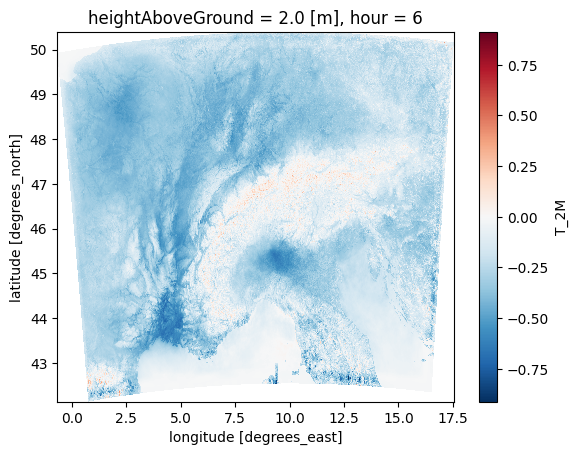

In [9]:
daily_cycle.sel(hour=6).plot.pcolormesh(
    x="longitude", y="latitude", cmap="RdBu_r"
)